<a href="https://colab.research.google.com/github/pranao0609/DL_Projects/blob/main/7_GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
import os
print(os.path.exists('/content/j.jpg'))  # Should return True


True


In [13]:
img_path = 'dog.jpg'
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)

In [11]:
import cv2

img = cv2.imread('dog.jpg')
if img is None:
    print("Image is not readable by OpenCV either.")
else:
    print("Image loaded successfully by OpenCV.")


Image loaded successfully by OpenCV.


In [14]:
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

In [15]:
target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

output = model(input_tensor)
class_idx = output.argmax().item()
model.zero_grad()
output[0, class_idx].backward()


grads = gradients[0]
acts = activations[0].detach()


weights = grads.mean(dim=[2, 3], keepdim=True)
cam = (weights * acts).sum(dim=1).squeeze()


cam = cam.cpu().numpy()
cam = np.maximum(cam, 0)
cam = cam / cam.max()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


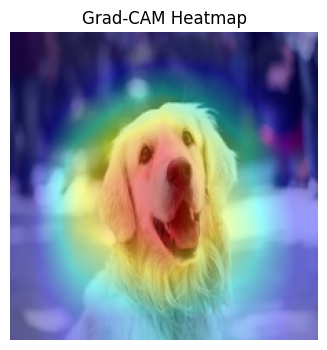

In [16]:
heatmap = cv2.resize(cam, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

original_img = cv2.cvtColor(np.array(img.resize((224, 224))), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)


plt.figure(figsize=(8, 4))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()